<a href="https://colab.research.google.com/github/jpscard/Unyleya_IA_Specialization/blob/main/Reconhecimento_de_captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *Atividade 6 - Deep Learning - Unyleya*
## *Aluno:João Paulo da Silva Cardoso*

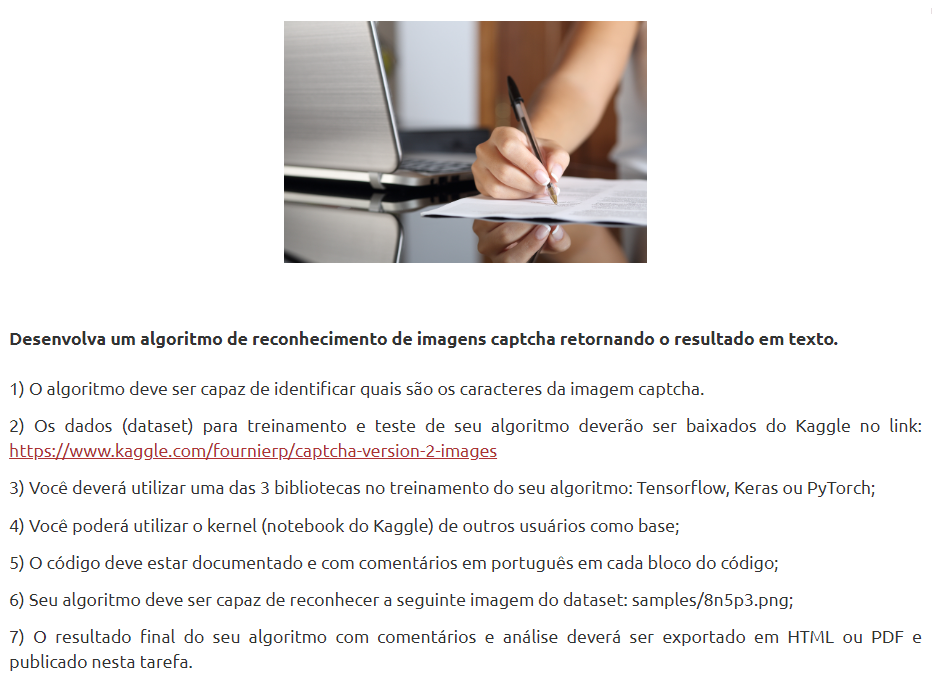

Dataset https://www.kaggle.com/fournierp/captcha-version-2-images

##**0 - Importando bibliotecas**

In [1]:
import numpy as np # álgebra Linear
import pandas as pd # processamento de dados, E/S de arquivo CSV (por exemplo, pd.read_csv)
# Os arquivos de dados de entrada estão disponíveis no diretório "../input/".
%matplotlib inline 
import matplotlib.pyplot as plt
import os
print(os.listdir("/content/input"))

['captchas', '.ipynb_checkpoints']


In [2]:
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np

#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

In [3]:
print(num_symbols)

36


##**1 - Criando o Modelo e Treinando**

In [4]:
def create_model():
    img = layers.Input(shape=img_shape) # Obter a imagem como uma entrada e processar por meio de algumas convoluções
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Obtem o vetor Flaten e faça 5 ramificações dele. Cada ramificação irá prever uma letra
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile o modelo e retorne-o
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [5]:
def preprocess_data():
    n_samples = len(os.listdir('/content/input/captchas/samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('/content/input/captchas/samples')):
        # Ler a imagem como tons de cinza
        img = cv2.imread(os.path.join('/content/input/captchas/samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Dimensionar e remodelar a imagem
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Defina alvos e codifique-os usando OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Retornar dados finais
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [6]:
model=create_model();
model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 200, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 100, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 100, 32)  4640        ['max_pooling2d[0][0]']      

In [7]:
# Treinar Modelo
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Epoch 1/30
25/25 [==============================] - 15s 391ms/step - loss: 17.5969 - dense_1_loss: 3.5825 - dense_3_loss: 3.4689 - dense_5_loss: 3.5122 - dense_7_loss: 3.5201 - dense_9_loss: 3.5131 - dense_1_accuracy: 0.0490 - dense_3_accuracy: 0.0374 - dense_5_accuracy: 0.0644 - dense_7_accuracy: 0.0696 - dense_9_accuracy: 0.0735 - val_loss: 17.7848 - val_dense_1_loss: 3.5598 - val_dense_3_loss: 3.5570 - val_dense_5_loss: 3.5505 - val_dense_7_loss: 3.5600 - val_dense_9_loss: 3.5575 - val_dense_1_accuracy: 0.0567 - val_dense_3_accuracy: 0.0876 - val_dense_5_accuracy: 0.1186 - val_dense_7_accuracy: 0.1082 - val_dense_9_accuracy: 0.0309
Epoch 2/30
25/25 [==============================] - 10s 376ms/step - loss: 16.4783 - dense_1_loss: 3.2974 - dense_3_loss: 3.2321 - dense_5_loss: 3.2997 - dense_7_loss: 3.3369 - dense_9_loss: 3.3123 - dense_1_accuracy: 0.0851 - dense_3_accuracy: 0.0812 - dense_5_accuracy: 0.0747 - dense_7_accuracy: 0.0631 - dense_9_accuracy: 0.0773 - val_loss: 17.6422 - va

###**2 - Predição usando o modelo treinado**

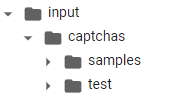

In [8]:
# Definir função para prever o captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5



In [9]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)

3/3 [==============================] - 0s 84ms/step - loss: 2.4254 - dense_1_loss: 0.0481 - dense_3_loss: 0.3043 - dense_5_loss: 0.4162 - dense_7_loss: 0.9843 - dense_9_loss: 0.6725 - dense_1_accuracy: 0.9792 - dense_3_accuracy: 0.9375 - dense_5_accuracy: 0.8958 - dense_7_accuracy: 0.7604 - dense_9_accuracy: 0.8125
Test Loss and accuracy: [2.4254157543182373, 0.048095401376485825, 0.3042629063129425, 0.4162440001964569, 0.984329879283905, 0.6724836230278015, 0.9791666865348816, 0.9375, 0.8958333134651184, 0.7604166865348816, 0.8125]


In [10]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict('/content/input/captchas/test/2b827.png'))
print(predict('/content/input/captchas/test/2bg48.png'))
print(predict('/content/input/captchas/test/2cegf.png'))
print(predict('/content/input/captchas/test/2cg58.png'))
print(predict('/content/input/captchas/test/2cgyx.png'))
print(predict('/content/input/captchas/test/2en7g.png'))

1/1 [==============================] - 0s 266ms/step
2b827
1/1 [==============================] - 0s 31ms/step
2bg48
1/1 [==============================] - 0s 29ms/step
2cegf
1/1 [==============================] - 0s 36ms/step
2cg58
1/1 [==============================] - 0s 34ms/step
2cgyx
1/1 [==============================] - 0s 30ms/step
2en7g


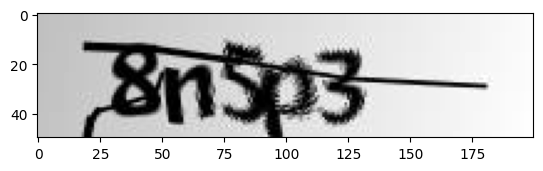

In [11]:
# Selecionando Elemento a ser predito  
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('/content/input/captchas/test/8n5p3.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [12]:
# Exibir Predição
print("Predicted Captcha =",predict('/content/input/captchas/test/8n5p3.png'))

1/1 [==============================] - 0s 28ms/step
Predicted Captcha = 8n5p3
